In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.stats import linregress

In [3]:
# Generate some example data by numerical integration (you can replace this with your own data)
def lorenz_system(t, state):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (rho - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


def lorenz_jac(x,y,z):
    dxxdt = -sigma
    dxydt = sigma
    dxzdt = 0
    dyxdt = rho-z
    dyydt = -1
    dyzdt = -x
    dzxdt = y
    dzydt = x
    dzzdt = -beta
    
    return np.array([[dxxdt,dxydt,dxzdt],
                     [dyxdt,dyydt,dyzdt],
                     [dzxdt,dzydt,dzzdt]])

def variational(t,p,counter,sol, pstor, mdot):
    
    
    xc = sol[0,counter]
    yc = sol[1,counter]
    zc = sol[2,counter]
    
    
    pstor.append(p)
    pertb_vecs = p.reshape((3,3))
    Mdot = (lorenz_jac(xc,yc,zc) * pertb_vecs).reshape(-1,)
    
    mdot.append(Mdot)
    
    counter +=1
    
    return Mdot


sigma=10 
beta=8/3 
rho=28
t = np.arange(0, 200, 0.01)  # Time points
initial_state = [0,1,1.05]              # Initial conditions
#initial_state = initial_state[:,np.newaxis].transpose()
#pertb0= np.eye(3).reshape(-1,1)
#pertb0=pertb0[:,0]
sol = scipy.integrate.solve_ivp(lorenz_system, (t[0], t[-1]), initial_state, t_eval=t)
#sol = scipy.integrate.solve_ivp(lorenz_system, (t[0], t[-1]), initial_state[0,:])

counter = 0 
pstor = []
mdot = []
#print(pertb0)
#print(np.shape(pertb0))
#solv = scipy.integrate.solve_ivp(variational, (t[0], t[-1]), pertb0,args=(counter,sol.y,pstor,mdot),t_eval = sol.t)

In [ ]:
#### Examples of how to convert numpy arrays: 

# creates a 1D numpy array:
lj = lorenz_jac(1,2,3)

# turn the 1D array to a 2D column vector
lj = lj[:,np.newaxis]

# turn the 2D column vector to a 2D row vector
#lf = lj.transpose()

In [ ]:
# calculate Lypaunov exponents
n = 3
pertb = solv.y
lyap_toSum = np.zeros((len(sol.t),n))
lyap = np.zeros((len(sol.t),n))
for i in range(np.shape(pertb)[1]):
    Mn = pertb[:,i].reshape((n,n))
    Q,R = np.linalg.qr(Mn)
    lyap_toSum[i,:] = np.log(abs(np.diagonal(R)))
    le = np.sum(lyap_toSum,axis=0) / sol.t[i]       
    lyap[i,:] = le
    
T = sol.t   

In [ ]:
lyap

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize=(10,8))
ax.plot(T,lyap[:,0])
ax.plot(T,lyap[:,1])
ax.plot(T,lyap[:,2])

ax.set(xlabel = 'T', ylabel = 'LEs',title='Lyapunov exponents: Lorenz')

## Stacked solve

In [ ]:
# Stacked solve
def lorenz_system_stacked(t, s, sys,M,xstor):
    x,y,z = s[0:3]

    pertb_vecs = s[3:].reshape((3,3)).transpose()
    
    sysdot = np.array([sigma * (y - x),
                       x * (rho - z) - y,
                       x * y - beta * z])
    
    Mdot = np.matmul(lorenz_jac(x,y,z),pertb_vecs).reshape(-1,1)
    
    sys.append(sysdot)
    M.append(np.concatenate((sysdot,Mdot)))
    
    
    return np.concatenate((sysdot,Mdot))


In [ ]:
sigma=10 
beta=8/3 
rho=28
t = np.arange(0, 200, 0.01)  # Time points
#initial_state = np.array([0,1,1.05])               # Initial conditions

initial_state = np.array([3.64,6.9,8.8])  
pertb0= np.eye(3).reshape(-1,1)
pertb0=pertb0[:,0]

s0 = np.concatenate((initial_state,pertb0))

In [ ]:
sys = []
M = []
xstor = []
sol = scipy.integrate.solve_ivp(lorenz_system_stacked, (t[0], t[-1]), s0, method='RK45', t_eval=None,
              dense_output=False, events=None, vectorized=True,
              args=(sys,M,xstor), rtol=1e-6)

In [ ]:
x = sol.y[0,:]
y = sol.y[1,:]
z = sol.y[2,:]
T = sol.t
ax = plt.figure().add_subplot(projection='3d')
ax.plot(x,y,z)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

In [ ]:
# calculate Lypaunov exponents
n = 3
pertb = sol.y[3:,:]
# lyap_toSum = np.zeros((len(sol.t),n))
# lyap = np.zeros((len(sol.t),n))
# for i in range(np.shape(pertb)[1]):
#     Mn = pertb[:,i].reshape((n,n))
#     Q,R = np.linalg.qr(Mn)
#     lyap_toSum[i,:] = np.log(abs(np.diagonal(R)))
#     le = np.sum(lyap_toSum,axis=0) / sol.t[i]       
#     lyap[i,:] = le



In [ ]:
lyap

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize=(10,8))
ax.plot(T,lyap[:,0])
ax.plot(T,lyap[:,1])
ax.plot(T,lyap[:,2])

ax.set(xlabel = 'T', ylabel = 'LEs',title='Lyapunov exponents: Lorenz')

In [ ]:
n = 3
pertb = sol.y[3:,:]

GALI2 = np.zeros((len(sol.t),1))
for i in range(len(sol.t)):
    # normalize the vectors first
    #normalized = pertb[0:6,i] / np.sqrt(np.sum(pertb[:,i]**2))
    
    v1 = pertb[0:3,i] / np.sqrt(np.sum(pertb[0:3,i]**2))
    v2 = pertb[3:6,i] / np.sqrt(np.sum(pertb[3:6,i]**2))
    
    Mn = np.vstack((pertb[0:3,i],pertb[3:6,i]))
    S = np.linalg.svd(Mn.transpose(),compute_uv=False)
    GALI2[i] = np.prod(S)

In [ ]:
### GALI2
fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize=(10,8))
ax.plot(sol.t,np.log10(GALI2))
ax.set(xlabel = 'T', ylabel = 'GALI2',title='GALI')

In [ ]:
for i in range(len(GALI2)):
    print(GALI2[i])

## Correlation dimension

In [4]:
x = sol.y[0,:]
y = sol.y[1,:]
z = sol.y[2,:]

xyz = list(zip(x,y,z))

In [5]:
distances = pdist(xyz)

In [6]:
N = len(x)
print(N)

20000


In [7]:
rmin = np.log10(np.min(distances))
print(rmin)

-2.2376263271743104


In [8]:
rmax = np.log10(np.max(distances))
print(rmax)

1.7881487132557718


In [22]:
#neighborhood radius
r_full = np.logspace(-2.5, 2, 50)

In [23]:
def correlation_integral(dist,r_range, N):
    '''
    dist: euclidean norm, without log being taken
    r_range: generated in logspace, but without log being taken
    N: number of total points/states of the system
    '''
     
    dist = np.log10(dist)
    r_range = np.log10(r_range)
    
    Cr = []
    for r in r_range:
        Cr.append(np.count_nonzero(dist < r)/N**2)
    
    return np.array(Cr)
            
        
    

In [24]:
C_full = correlation_integral(distances,r_full,N)

/var/folders/pj/dbrv8fy57dg5n_h6f7ldx89c0000gp/T/ipykernel_41228/1218093049.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(r_full),np.log10(C_full),'bo')


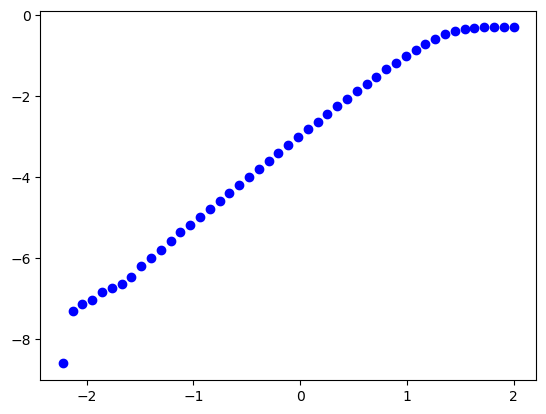

In [25]:
ax = plt.figure().add_subplot()
ax.plot(np.log10(r_full),np.log10(C_full),'bo')

In [26]:
C_full*N**2

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       2.00000000e+01, 2.90000000e+01, 3.60000000e+01, 5.80000000e+01,
       7.40000000e+01, 9.30000000e+01, 1.35000000e+02, 2.50000000e+02,
       4.03000000e+02, 6.38000000e+02, 1.07600000e+03, 1.72300000e+03,
       2.67100000e+03, 4.12900000e+03, 6.48000000e+03, 1.01840000e+04,
       1.58470000e+04, 2.51910000e+04, 4.00860000e+04, 6.34070000e+04,
       1.02131000e+05, 1.61555000e+05, 2.51825000e+05, 3.93826000e+05,
       6.11930000e+05, 9.47412000e+05, 1.46220800e+06, 2.25450500e+06,
       3.46648700e+06, 5.31638200e+06, 8.11610000e+06, 1.22971590e+07,
       1.84022430e+07, 2.71077920e+07, 3.92536590e+07, 5.56876460e+07,
       7.75099850e+07, 1.05518991e+08, 1.37837918e+08, 1.67669961e+08,
       1.87955156e+08, 1.97940441e+08, 1.99963634e+08, 1.99990000e+08,
       1.99990000e+08, 1.99990000e+08])

In [27]:
fitstart = 4
fitend = -6
r_fit = r_full[fitstart:fitend]
C_fit = C_full[fitstart:fitend]
line_fit=linregress(np.log10(r_fit),np.log10(C_fit))
print(line_fit)

LinregressResult(slope=2.048102088015731, intercept=-3.0502019346860325, rvalue=0.9990874489477357, pvalue=1.1755966500214867e-53, stderr=0.01420367675726679, intercept_stderr=0.015820887415060682)


/var/folders/pj/dbrv8fy57dg5n_h6f7ldx89c0000gp/T/ipykernel_41228/3258585641.py:2: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(r_full),np.log10(C_full),'bo')


[Text(0.5, 0, '$log_{10} \\: r $'), Text(0, 0.5, '$log_{10} \\: C(r) $')]

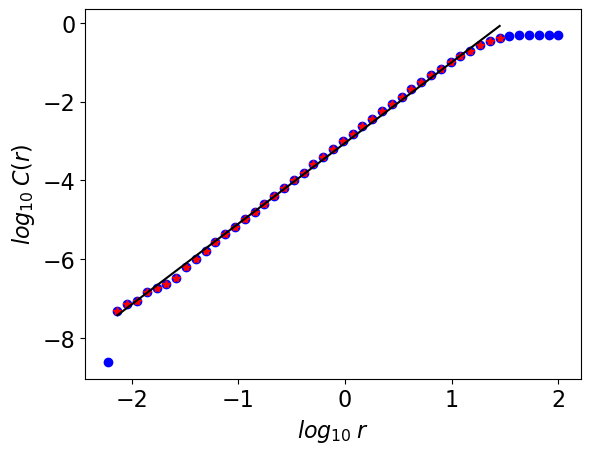

In [29]:
ax = plt.figure().add_subplot()
ax.plot(np.log10(r_full),np.log10(C_full),'bo')
ax.plot(np.log10(r_fit),np.log10(C_fit),'r*')
ax.plot(np.log10(r_fit),line_fit.slope*np.log10(r_fit)+line_fit.intercept,color='black')
plt.rcParams.update({'font.size': 16})
ax.set(xlabel=r'$log_{10} \: r $',ylabel=r'$log_{10} \: C(r) $')